# OpenET SIMS
## Collection "Interpolate" Examples

In [1]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import openet.sims as model

ee.Initialize()

In [2]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

## Input parameters

In [3]:
collections = ['LANDSAT/LC08/C01/T1_SR']

etr_source = 'projects/climate-engine/cimis/daily'
etr_band = 'ETo'
# etr_source = 'IDAHO_EPSCOR/GRIDMET'
# etr_band = 'eto'

# Date range you want to aggregate ET over
# End date is inclusive (like filterDate() calls)
start_date = '2017-07-01'
end_date = '2017-08-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_method = 'LINEAR'

test_point = ee.Geometry.Point(-121.5265, 38.7399)
study_area = ee.Geometry.Rectangle(-122.00, 38.50, -121.00, 39.0)

# Hard code the study area and CRS
study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()
study_crs = 'EPSG:32610'

## Build the collection object

In [4]:
model_obj = model.Collection(
    collections=collections,
    etr_source=etr_source, 
    etr_band=etr_band,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
    # filter_args={},
)

This isn't returning the images used for interpolation.  Should it?

In [5]:
pprint.pprint(model_obj.get_image_ids())

['LANDSAT/LC08/C01/T1_SR/LC08_044033_20170716']


In [6]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict)

## Interpolate Daily ET

In [7]:
et_daily_coll = model_obj.interpolate(
    t_interval='daily', 
    variables=['et', 'etr', 'etf'], 
    interp_method=interp_method,
    interp_days=interp_days,
)
et_daily_df = get_region_df(et_daily_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(et_daily_df)
print('')
pprint.pprint(et_daily_df[['et', 'etr']].sum())

                  et       etr       etf
2017-07-01  5.591747  7.257332  0.770496
2017-07-02  5.751506  7.285856  0.789407
2017-07-03  5.911264  7.314379  0.808170
2017-07-04  6.071023  7.342903  0.826788
2017-07-05  6.230782  7.371426  0.845261
2017-07-06  6.390541  7.399950  0.863593
2017-07-07  6.550300  7.428473  0.881783
2017-07-08  6.710058  7.456996  0.899834
2017-07-09  6.869817  7.485519  0.917747
2017-07-10  7.029576  7.514043  0.935525
2017-07-11  7.189334  7.542566  0.953168
2017-07-12  7.349093  7.571090  0.970678
2017-07-13  7.508852  7.599613  0.988057
2017-07-14  7.668611  7.628137  1.005306
2017-07-15  7.828369  7.656660  1.022426
2017-07-16  7.988128  7.685184  1.039419
2017-07-17  7.965028  7.665400  1.039088
2017-07-18  7.941929  7.645616  1.038756
2017-07-19  7.918829  7.625831  1.038422
2017-07-20  7.895730  7.606047  1.038086
2017-07-21  7.872630  7.586263  1.037748
2017-07-22  7.849531  7.566479  1.037409
2017-07-23  7.826431  7.546695  1.037067
2017-07-24  7.80

## Interpolate Monthly ET

In [8]:
et_monthly_coll = model_obj.interpolate(
    t_interval='monthly', 
    variables=['et', 'etr', 'etf'], 
    interp_method=interp_method,
    interp_days=interp_days,
)
et_monthly_df = get_region_df(et_monthly_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(et_monthly_df)

                    et         etr      etf
2017-07-01  225.688965  232.443787  0.97094


## Sum of Daily ET (for one month)

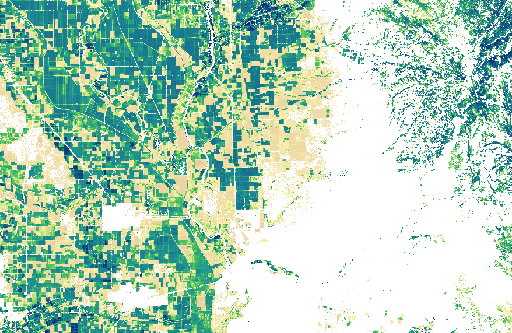

In [9]:
Image(url=ee.Image(et_daily_coll.select(['et']).sum())\
        .reproject(crs=study_crs, scale=100)\
        .getThumbURL({'min': 0.0, 'max': 300, 'palette': et_palette, 'region': study_region}),
      embed=True, format='png') 

## Monthly ET (for one month)

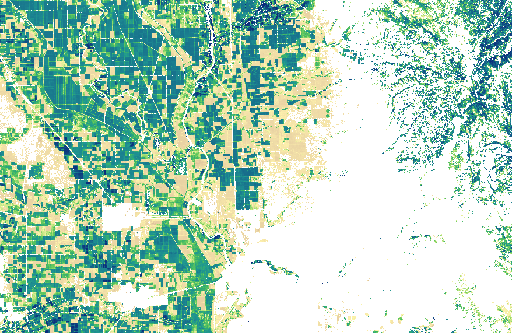

In [10]:
Image(url=ee.Image(et_monthly_coll.select(['et']).sum())\
        .reproject(crs=study_crs, scale=100)\
        .getThumbURL({'min': 0.0, 'max': 300, 'palette': et_palette, 'region': study_region}),
      embed=True, format='png') 

## Monthly ETr (for one month)

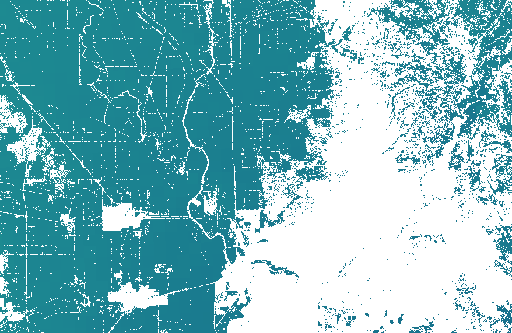

In [11]:
Image(url=ee.Image(et_monthly_coll.select(['etr']).sum())\
        .reproject(crs=study_crs, scale=100)\
        .getThumbURL({'min': 0.0, 'max': 300, 'palette': et_palette, 'region': study_region}),
      embed=True, format='png') 